In [1]:
import numpy as np
import pandas as pd
from data_reader import read_consumption_and_weather
import torch
import torch.nn as nn
import torch.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import copy

from utils import *

from models.lstm_model import LSTMModel

torch.manual_seed(1)

In [2]:
_, _, df = read_consumption_and_weather()

df1 = df['NO1']
df2 = df['NO2']
df3 = df['NO3']
df4 = df['NO4']
df5 = df['NO5']

Holes by length and occurrences in column NO3:
Filling holes up to length 3
Any remaining holes after interpolation? False


In [3]:
df = df1[['consumption']]

df

,consumption
2017-05-01 00:00:00+00:00,3325.431995
2017-05-01 01:00:00+00:00,3344.690998
2017-05-01 02:00:00+00:00,3398.359002
2017-05-01 03:00:00+00:00,3430.220001
2017-05-01 04:00:00+00:00,3606.750000
...,...
2023-01-21 19:00:00+00:00,5947.502808
2023-01-21 20:00:00+00:00,5868.196111
2023-01-21 21:00:00+00:00,5742.156776
2023-01-21 22:00:00+00:00,5653.673398


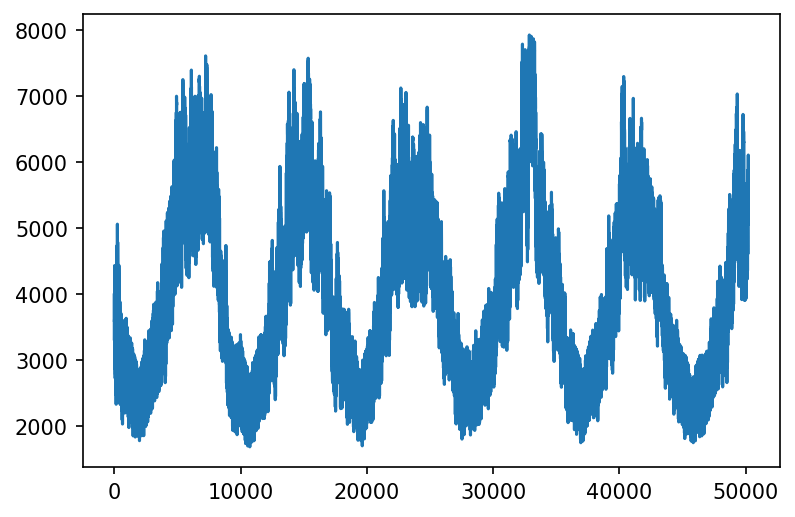

In [4]:
plt.figure(figsize=(6, 4), dpi=150)
plt.plot(range(len(df['consumption'].values)), df['consumption'].values)
plt.show()

In [5]:
# Get the 0.8 first timesteps for training and 0.2 last one for testing
df_train, df_test = train_test_split(df, test_size=0.1, shuffle=False)
# Divide into train, validation
df_train, df_validation = train_test_split(df_train, test_size=0.1, shuffle=False)

In [6]:
# Save for undoing normalization in testing
train_mean = df_train.mean()
train_std = df_train.std()

# Normalize train and test set
df_train = (df_train - train_mean) / train_std
df_validation = (df_validation - train_mean) / train_std
df_test = (df_test - train_mean) / train_std

In [7]:
df_train

,consumption
2017-05-01 00:00:00+00:00,-0.520736
2017-05-01 01:00:00+00:00,-0.506271
2017-05-01 02:00:00+00:00,-0.465960
2017-05-01 03:00:00+00:00,-0.442029
2017-05-01 04:00:00+00:00,-0.309436
...,...
2021-12-20 07:00:00+00:00,1.151071
2021-12-20 08:00:00+00:00,1.168536
2021-12-20 09:00:00+00:00,1.153706
2021-12-20 10:00:00+00:00,1.116430


In [8]:
class SequenceDataset(torch.utils.data.Dataset):

    def __init__(self, df):
        self.data = df

    def __getitem__(self, idx):
        sample = self.data[idx]
        return torch.Tensor(sample['sequence']), torch.Tensor(sample['target'])
    
    def __len__(self):
        return len(self.data)
    
    

In [9]:
tw = 100
pw = 1

train_dataset = SequenceDataset(generate_lstm_sequences(df_train, tw, pw))
val_dataset = SequenceDataset(generate_lstm_sequences(df_validation, tw, pw))
test_dataset = SequenceDataset(generate_lstm_sequences(df_test, tw, pw))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True, drop_last=True)

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [11]:
# Init model
model = LSTMModel(device=device, n_features=1, n_hidden=64, n_outputs=1, sequence_len=100)
model.to(device)
model

LSTMModel(
  (lstm): LSTM(1, 64, batch_first=True)
  (fc1): Linear(in_features=6400, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)

In [12]:
next(model.parameters()).device

device(type='cuda', index=0)

In [13]:
def validation(val_loader, criterion, model):
    model.eval()
    val_losses = []
    for x, y in val_loader:
        x, y = x.to(device), y.to(device)
        y = y.squeeze()
        preds = model(x).squeeze()
        val_loss = criterion(preds, y)
        val_losses.append(val_loss)
    print(f"Validation Loss: {sum(val_losses) / len(val_losses)}")
    return sum(val_losses) / len(val_losses)

In [14]:
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005)

losses = []
losses_show = []
val_losses = []

for epoch in range(20):
    model.train()

    epoch_loss = []

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)

        y = y.squeeze()
        
        optimizer.zero_grad()

        preds = model(x).squeeze()

        loss = criterion(preds, y)
        losses.append(loss.item())

        loss.backward()

        optimizer.step()
        
        losses.append(loss.item())
        epoch_loss.append(loss.item())
        if len(losses) > 20:
            losses_show.append(sum(losses[-20:]) / 20)
        else:
            losses_show.append(losses[-1])
    
    print(f"Epoch {epoch} train loss: {sum(losses) / len(losses)}")
    val_loss = validation(val_loader, criterion, model)
    val_losses.append(val_loss)

# Save model parameters
torch.save(model.state_dict(), 'trained_models/lstm.pth')

Epoch 0 train loss: 0.02522935490465731
Validation Loss: 0.00779658742249012
Epoch 1 train loss: 0.015409493664286563
Validation Loss: 0.003932795487344265
Epoch 2 train loss: 0.01114268389417648
Validation Loss: 0.001753796124830842
Epoch 3 train loss: 0.00876480876576084
Validation Loss: 0.0012757987715303898
Epoch 4 train loss: 0.0072786072134611805
Validation Loss: 0.0015320878010243177
Epoch 5 train loss: 0.006278322330650966
Validation Loss: 0.0012480018194764853
Epoch 6 train loss: 0.005546323505916953
Validation Loss: 0.0010144965490326285
Epoch 7 train loss: 0.004987157786706925
Validation Loss: 0.0014088340103626251
Epoch 8 train loss: 0.004552979019278295
Validation Loss: 0.0010666768066585064
Epoch 9 train loss: 0.004200432176857742
Validation Loss: 0.00097967020701617
Epoch 10 train loss: 0.003906234317148177
Validation Loss: 0.0009013430681079626
Epoch 11 train loss: 0.0036566446179896756
Validation Loss: 0.0015357786323875189
Epoch 12 train loss: 0.0034467059409114854
Va

1267


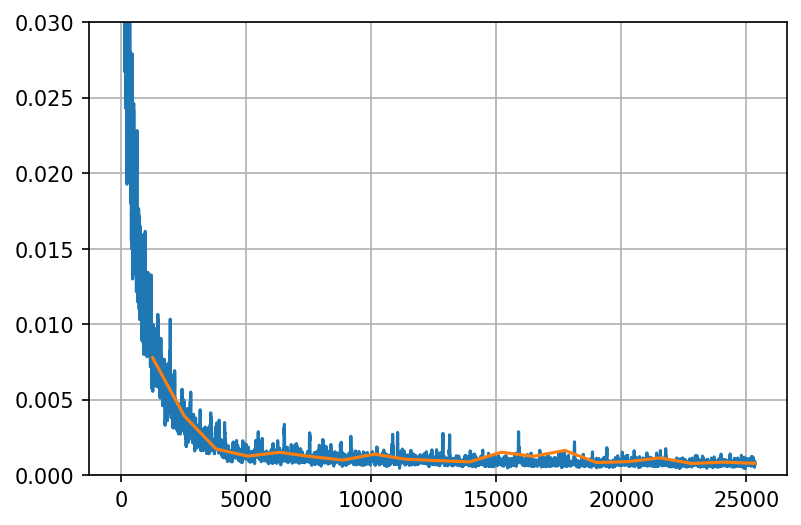

In [15]:
plt.figure(figsize=(6, 4), dpi=150)
plt.grid()
plt.ylim(0, 0.03)

print(len(losses_show) // len(val_losses))

plt.plot(range(len(losses_show)), losses_show)
plt.plot(range(len(losses_show) // len(val_losses), len(losses_show)+1, len(losses_show) // len(val_losses)), val_losses)
plt.show()

In [16]:
def make_preds(model, test_loader, criterion):
    model.eval()
    predictions, actuals, test_losses = [], [], []
    for x, y in test_loader:
        with torch.no_grad():
            x, y = x.to(device), y.to(device)
            p = model(x).squeeze()
            predictions.append(p)
            actuals.append(y.squeeze())
            loss = criterion(p, y.squeeze())
            test_losses.append(loss)
    predictions = torch.cat(predictions).cpu().numpy()
    actuals = torch.cat(actuals).cpu().numpy()
    test_loss = sum(test_losses) / len(test_losses)
    return predictions.squeeze(), actuals, test_loss

In [17]:
predictions, actuals, test_loss = make_preds(model, test_loader, criterion)

In [18]:
print(predictions * train_std['consumption'] + train_mean['consumption'])
print(actuals * train_std['consumption'] + train_mean['consumption'])

[2031.9404 5219.441  1940.2517 ... 4313.5273 2359.4917 5147.9434]
[2052.846  5341.306  2008.4921 ... 4333.5522 2382.1987 5130.4766]


In [19]:
print(f"Final test loss: {test_loss}")

Final test loss: 0.0005895494250580668


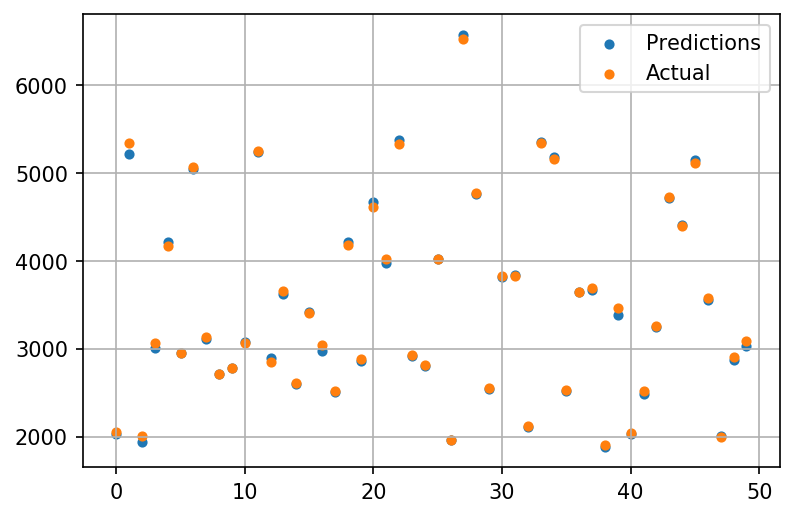

In [20]:
n = 50

pred = predictions[0:n] * train_std['consumption'] + train_mean['consumption']
act = actuals[0:n] * train_std['consumption'] + train_mean['consumption']

x = pred.shape[0]
plt.figure(figsize=(6, 4), dpi=150)
plt.grid()
plt.scatter(range(x), pred, label="Predictions", s=15)
plt.scatter(range(x), act, label="Actual", s=15)
plt.legend()
plt.show()

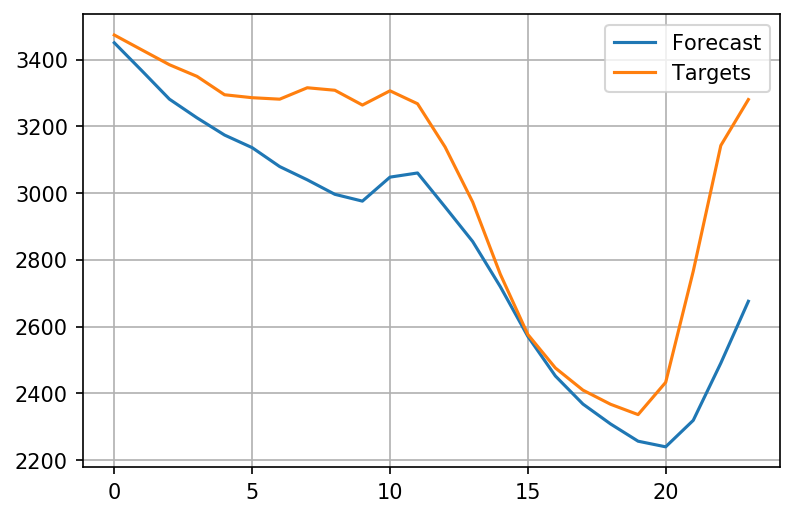

In [28]:
# Forecasting
start_point = 2000
tw = 100
fw = 24

history = list(df_test.copy(deep=True)['consumption'])[start_point: start_point+tw+fw]
targets = copy.deepcopy(history)[tw:tw+fw]

predictions = []

# 24 timesteps into the future
for i in range(fw):
    x = np.array(history[i:tw+i]).reshape(-1, 1)

    x = torch.Tensor(x).unsqueeze(0).to(device)
    pred = model(x)

    predictions.append(pred.item())

    history[-fw+i] = pred.item()

predictions = np.array(predictions) * train_std['consumption'] + train_mean['consumption']
targets = np.array(targets) * train_std['consumption'] + train_mean['consumption']

x = range(predictions.shape[0])
plt.figure(figsize=(6, 4), dpi=150)
plt.plot(x, predictions, label="Forecast")
plt.plot(x, targets, label="Targets")
plt.legend()
plt.grid()
plt.show()
